# Automated Qakbot Stage1 Analysis Part 1

## Background
This analysis will be spread out across two different notebooks. In this one i detail analysis around the initial stager. I do not focus on a full technical analysis of the sample. Im only focusing on the components of analysis that caused me to write some type of automation. I use BinaryNinja and the scripts are written to be run inside the UI via the Snippets plugin. This way i can take advantage of some of the magic helpers available when scripting in the UI. For instance you'll notice that i don't use a file path to the BinaryNinja database that i'm modifying in any of the scripts.  

## Automation Task for qakbot_unpacked_stage_1.bin  

* resolve API's[DONE]  
* decrypt strings [Done]   
* Automated unpacking [Done]   
* extract and decrypted embedded Resource [TODO]   
  * Encryption keys [TODO]    
  * SHA1 Hashes (used to verify resource and config data)[TODO]  
  

## File Identification
### qakbot-packed.exe  
- File:    qakbot-packed.exe  
- Size:    2804224 bytes  
- Type:    PE32 executable (GUI) Intel 80386, for MS Windows  
- MD5:     6f9e304b289770a66e089ae2be83952c  
- SHA1:    629c55b8e3e4fd9a6c0a4463ef5d30ceda133eb8  
- SHA256:  b92c0aafb4e9b0fc2b023dbb14d7e848249f29e02b0e4cd8624ce27e55c9ac4c  
- Compile: 0x17ACD825 [Tue Aug  3 06:18:13 1982 UTC] 

### Qakbot Stage1 Unpacked  
- File:    qakbot_unpacked_stage_1.bin  
- Size:    225280 bytes
- Type:    PE32 executable (GUI) Intel 80386, for MS Windows
- MD5:     b88f7b3a994875f43709345d38337c0d
- SHA1:    b687de53d02e41caa19ce1b433572f3b8fb2e973
- SHA256:  6cd66d76f9d3ffeb323f4202a8b715d6f59d1f781b006c5869695de446b057fd  
- Compile: 0x5F32BF98 [Tue Aug 11 15:56:08 2020 UTC]  

## Unpacking   
Ref: https://docs.microsoft.com/en-us/archive/msdn-magazine/2002/february/inside-windows-win32-portable-executable-file-format-in-detail  
Ref: https://docs.microsoft.com/en-us/archive/msdn-magazine/2002/march/inside-windows-an-in-depth-look-into-the-win32-portable-executable-file-format-part-2  
Ref: https://docs.microsoft.com/en-us/archive/msdn-magazine/2002/march/windows-2000-loader-what-goes-on-inside-windows-2000-solving-the-mysteries-of-the-loader  
Ref: https://github.com/Vector35/deprecated_python_debugger/blob/master/documentation/Manual.md  

When I first wrote this section I initially was not going to cover the unpacking process. As I was debugging and preparing to write the resource extraction I unintentionally wrote code that allowed me to automatically unpack the first stage payload as well. Holding true to the premise of only writing about anything that caused me to code I'll explain the process. Ironically the catalyst for writing the unpacker was a little bit of a happy accident. The first draft of this said to put a breakpoint on `VirtualAlloc`. That was a typo on my part but it caused me to go down a rather long rabbit hole but it was well worth it in the end. 

Qbot uses a self-injecting technique in order to unpack itself by overwriting its own PE header. The first thing it does is make a call to `VirtualAllocEx` and allocate 0x34000 bytes (212KB) in order to copy an encrypted shellcode payload that acts as the unpacking stub. 

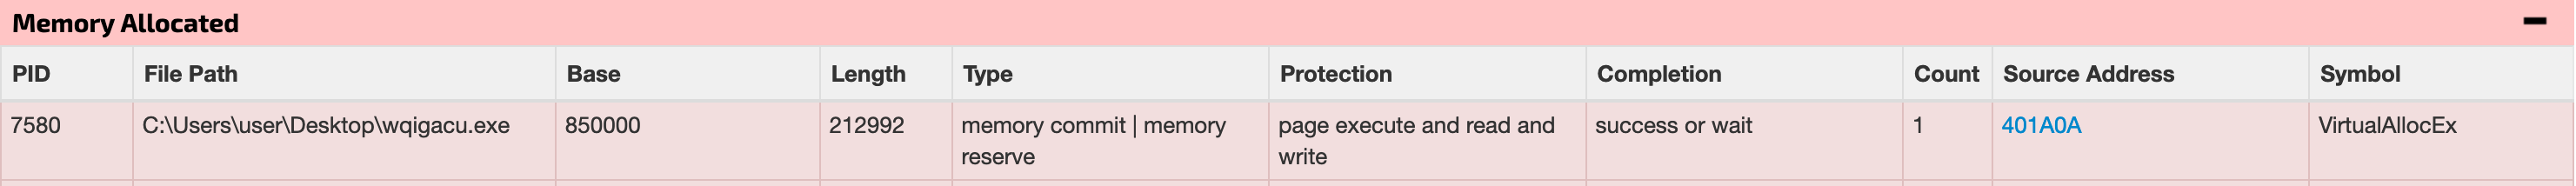  

The stub is decrypted and control is transfered to it. Interesting enough during my debugging session I realized that for some reason x64dbg would not break on `VirtualAlloc`. Because i was following my own typo I couldn't figure out why my breakpoint wouldn't hit. Following the unpacking process more meticulously I noticed that after the unpacking stub is decrypted you can see the API's the shellcode will call. Turns out `VirtualAlloc` is mis-spelled to `1irtualAlloc`.  

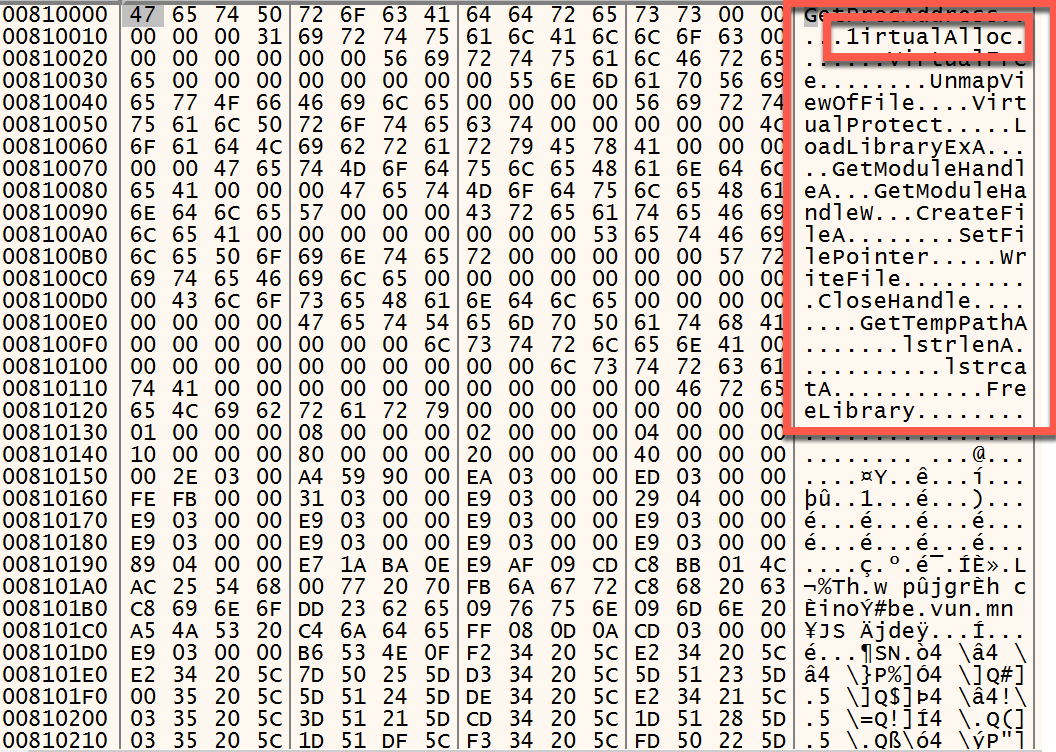  

At this point qbot is ready to overwrite its own PE header. A call to `VirtualProtect` is made to change the memory permissions to  `PAGE_EXECUTE_READWRITE` (0x40) on the regeion that will be overwritten. After the call to `VirtualProtect` returns the top of the stack will point to the address of the unmapped qbot payload. At this point we dump the address pointed to by ESP we have a our nicely minted unpacked qbot payload.  

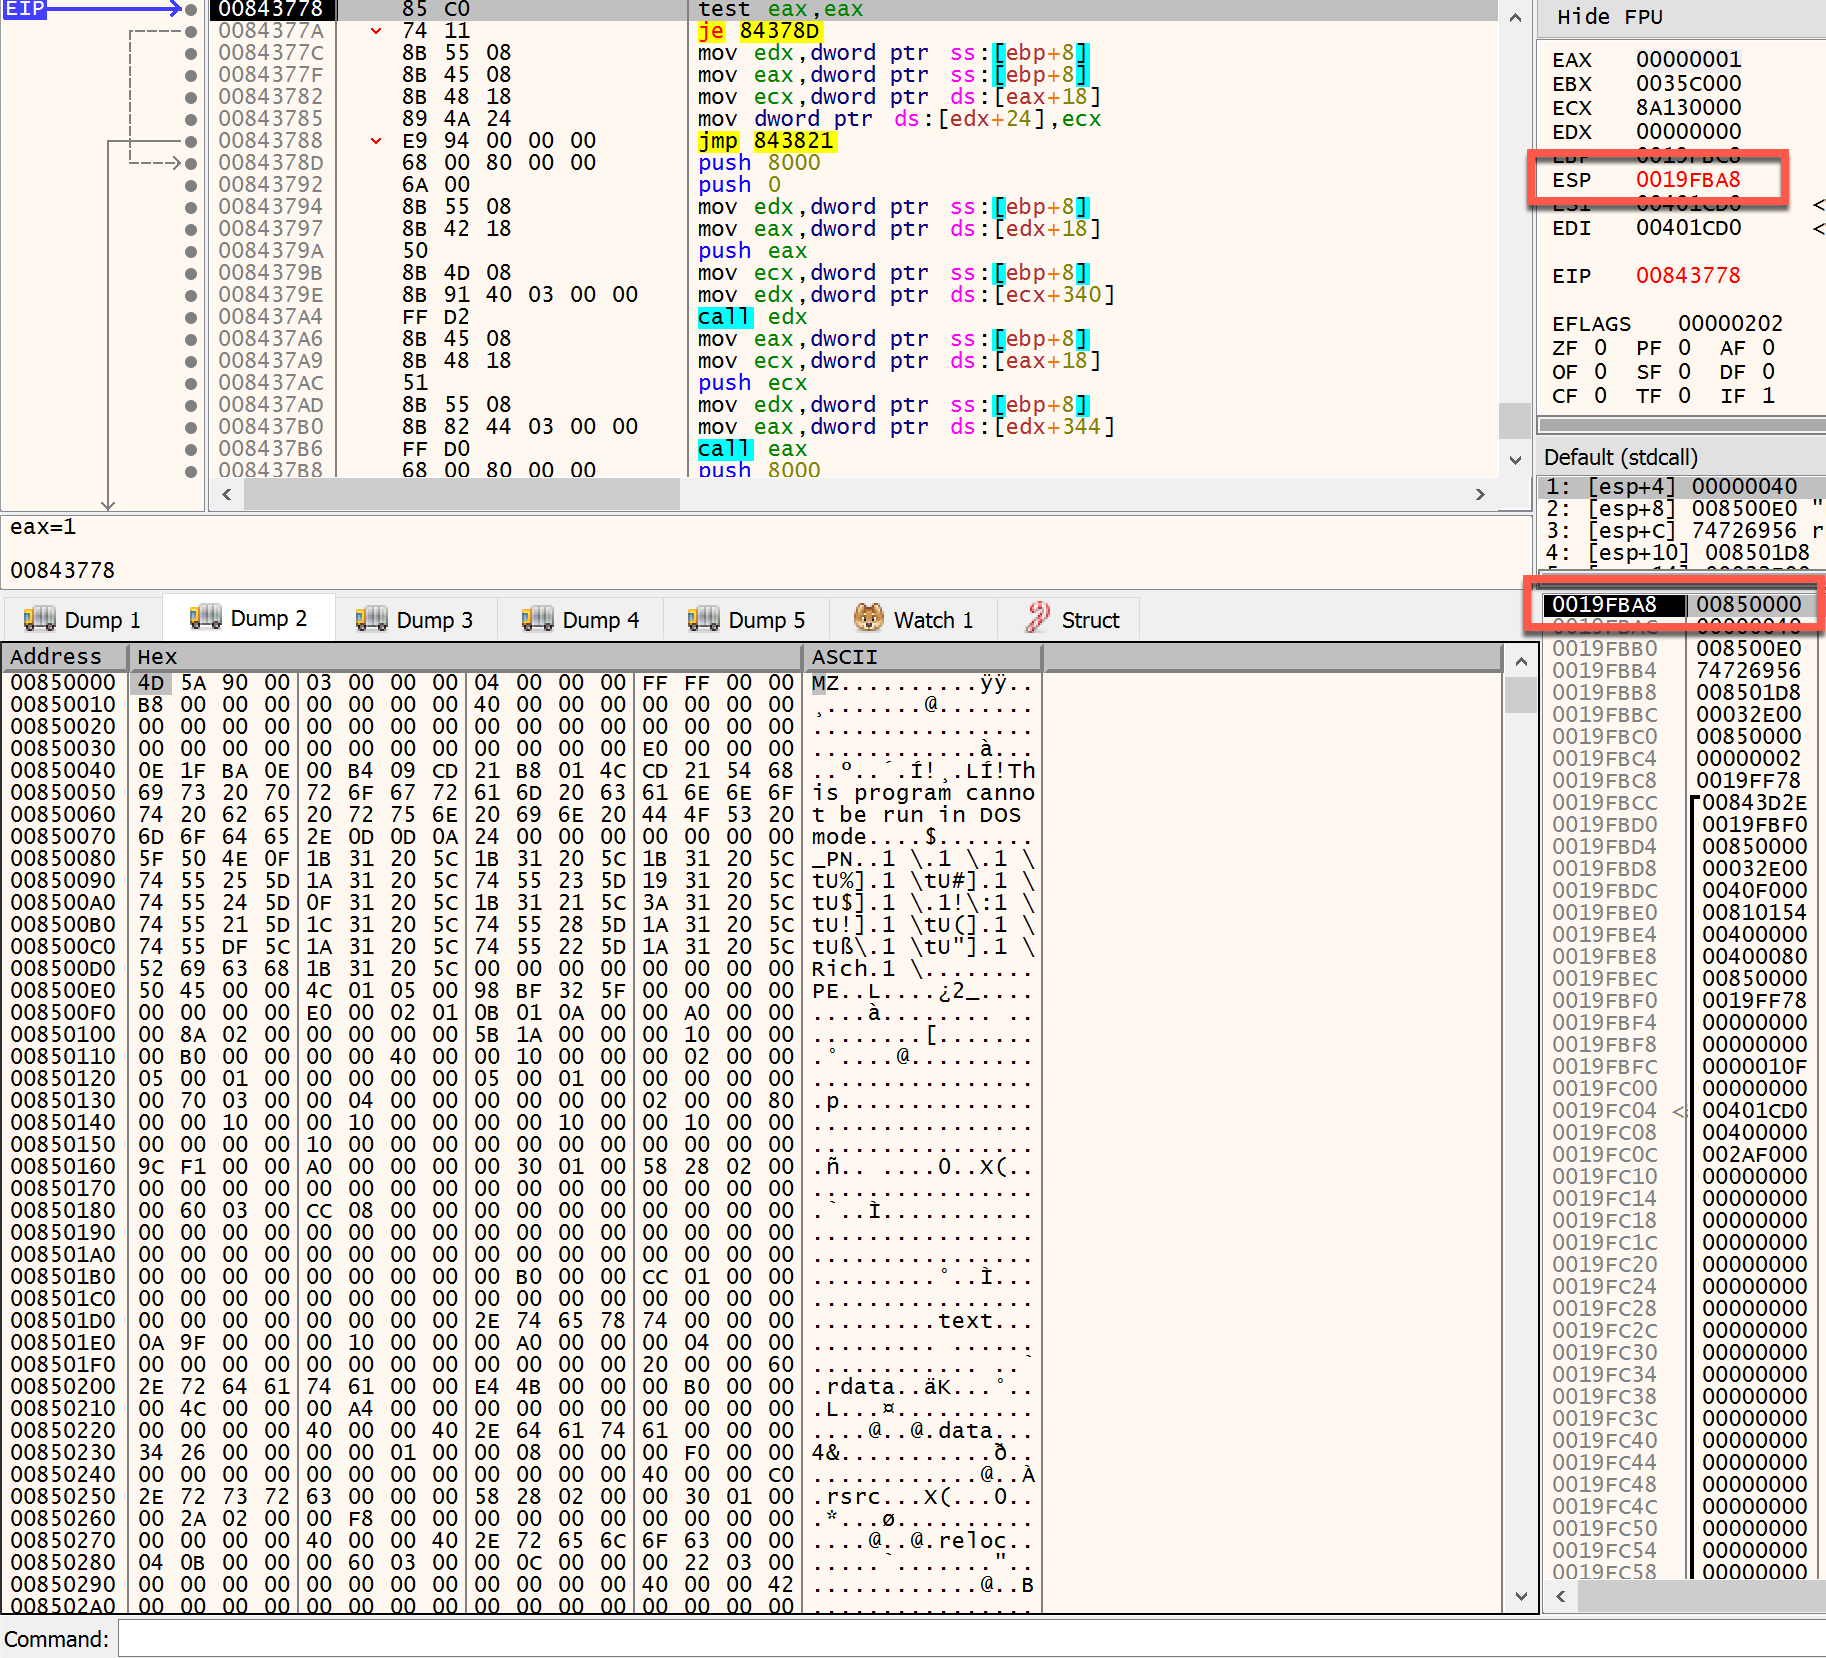  







In [ ]:
import pefile
from Vector35_debugger import DebugAdapter, dbgeng

# This is using the now depreciated debugger pluggin

def get_export_symbols(adapter):
    exports = {} 
    
    # Get loaded modules and base address
    for k, v in adapter.mem_modules().items():
        if "image" in k:
            continue
        if k == "ntdll.dll":
            k = "C:\\Windows\\SysWOW64\\ntdll.dll"        

        # Get the symbols from disk and resolve absolute address for export
        pe = pefile.PE(k)
        for exp in pe.DIRECTORY_ENTRY_EXPORT.symbols:
            if exp.name != None:
                exports.update({exp.name:v + exp.address})
               
    return exports
        
# Setup target for debugging
pe = "C:\\Users\\<name>\Desktop\\<sample>"
adapter = dbgeng.DebugAdapterDbgeng()
adapter.exec(pe, args=None)

# Setup initial breakpoint on entry point
adapter.breakpoint_set(0x401cd0) 

reason, data = adapter.go()

while adapter.breakpoint_list() != None:
    adapter.go()  
    
    if adapter.get_last_breakpoint_address() == 0x401cd0:
        print(f"[+] Building export lookup table...This may take several seconds")
        export_lookup = get_export_symbols(adapter)
        adapter.breakpoint_set(export_lookup.get(b"VirtualProtect"))
        adapter.breakpoint_clear(0x401cd0)
        adapter.go()

    if adapter.get_last_breakpoint_address() == export_lookup.get(b"VirtualProtect"):
        print("f[+] Unpacking stage1 Qbot payload")
        stack = adapter.reg_read("esp")
        ret = int.from_bytes(adapter.mem_read(stack, 0x4), "little")
        adapter.breakpoint_set(ret) 
        
        stack = adapter.reg_read("esp") + 0x8 # 2 param to VirtualProtect
        size = int.from_bytes(adapter.mem_read(stack, 0x4), "little")
        
        # Execute until return then grab the unpacked payload
        adapter.go()
        
        if adapter.reg_read("eip") == ret:
            stack = adapter.reg_read("esp")
            payload_addr = int.from_bytes(adapter.mem_read(stack, 0x4), "little")
            stage1_payload = adapter.mem_read(payload_addr, size)
            
            print(f"[+] Saving unpacked stage1 payload as {hex(payload_addr)}-unpacked.bin")
            with open(f"C:\\Users\\<name>\\Desktop\\{hex(payload_addr)}-unpacked.bin", mode="wb") as f:
                f.write(stage1_payload)
        
        adapter.quit()
        break
        

In [ ]:
import pefile
from binaryninja.debugger import debuggercontroller

#This is ported from the orgininal script to use the new native BinaryNinja Debugger 

def get_export_symbols(dbg):
    exports = {} 
    
    # Get loaded modules and base address
    for mods in dbg.modules:
        if "image" in mods.name:
            continue
        if mods.name == "ntdll.dll":
            continue
        
        # Get the symbols from disk and resolve absolute address for export
        pe = pefile.PE(mods.name)
        for exp in pe.DIRECTORY_ENTRY_EXPORT.symbols:
            if exp.name != None:
                exports.update({exp.name:mods.address + exp.address})
               
    return exports

dbg = debuggercontroller.DebuggerController(bv)

# Execute to main entry point 
dbg.launch()

# Build export lookup table
export_lookup = get_export_symbols(dbg)

virtual_protect = export_lookup.get(b"VirtualProtect")
dbg.add_breakpoint(virtual_protect)

while dbg.breakpoints != None:
    dbg.go_and_wait()

    if dbg.ip == virtual_protect:
        print(f"[+] Unpacking Qbot stage1 payload")
        stack = dbg.get_reg_value("esp")
        ret = dbg.read_memory(stack, 0x4)
        ret_addr = int.from_bytes(bytes(ret), "little")
        dbg.add_breakpoint(ret_addr)

        stack = dbg.get_reg_value("esp") + 0x8 #2nd param to VirtualProtect
        size = dbg.read_memory(stack, 0x4)
        size_bytes = int.from_bytes(bytes(size), "little")
        
        # Execute until return then grab the unpacked payload
        dbg.go_and_wait()
        
        if dbg.get_reg_value("eip") == ret_addr:
            stack = dbg.get_reg_value("esp")
            payload_addr = dbg.read_memory(stack, 0x4) #Top of Stack
            payload_addr_bytes = int.from_bytes(bytes(payload_addr), "little")
            stage1_payload = dbg.read_memory(payload_addr_bytes, size_bytes) 
           
            print(f"[+] Saving unpacked stage1 payload as {hex(payload_addr_bytes)}-unpacked.bin")
            with open(f"C:\\Users\\REM\\Desktop\\{hex(payload_addr_bytes)}-unpacked.bin", mode="wb") as f:
                f.write(bytes(stage1_payload))       
            
        dbg.quit()
        break

## API Resolution and String Decryption 
All of Qbots strings to include names of APIs and DLL imports are obfuscated using the same algorithm which is implmemented in two different subroutines. I can only assume this was a possible anti-analysis technique to slow things down.  


When Qbot first executes it checks its own process commandline argument and if the checks succeeds it will then attempt to resolve the imports needed from kernel32.dll. It does this by making a call to `mw_init`.  If the call fails the Qbot loader terminates execution. 

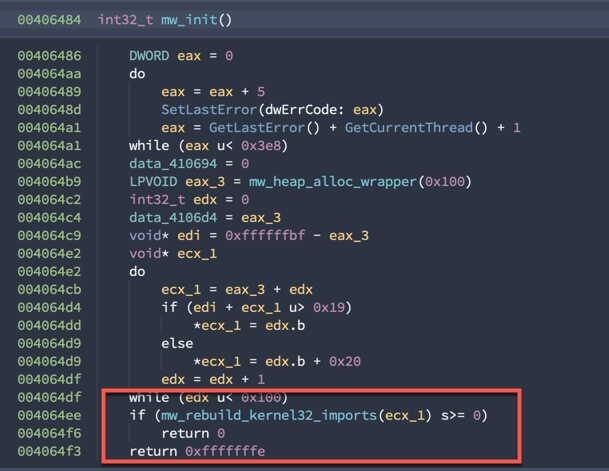  

In order to rebuild the iat Qbot first has to locate and get a handle to kernel32.dll. Then it will call `mw_resolve_import` and pass the address of a lookup table as parameter seen below. 

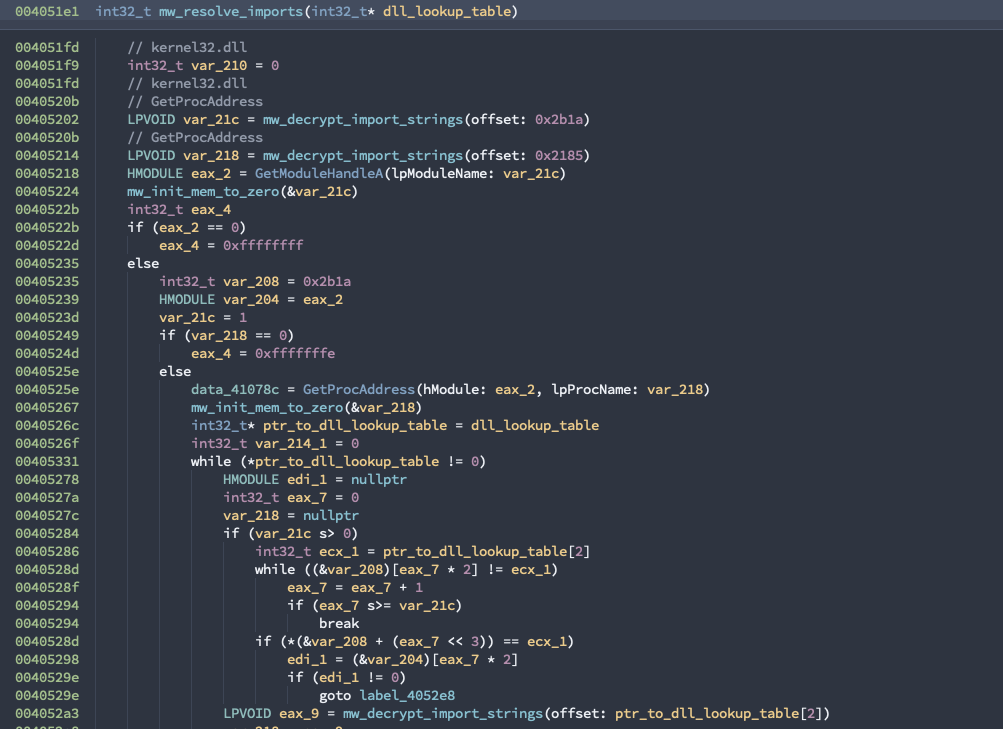  

The lookup table breaks down like the following: \<resolved_import_address>, \<api_name_offset\>, \<dll_name_offset\>. Offsets are used as lookups into the encrypted byte array (stored at address 0x40b8980) when passed to `mw_decrypt_import_strings` to decrypt and access the name of the dll and assoicated imports. 

  

For example, in the screenshots below you can see that the resolved import address will be `0x4107f8`, the API offset is 0x36bf-`CreateToolhelp32Snapshot` and the dll_name offset is 0x2b1a-`kernel32.dll`. 

  

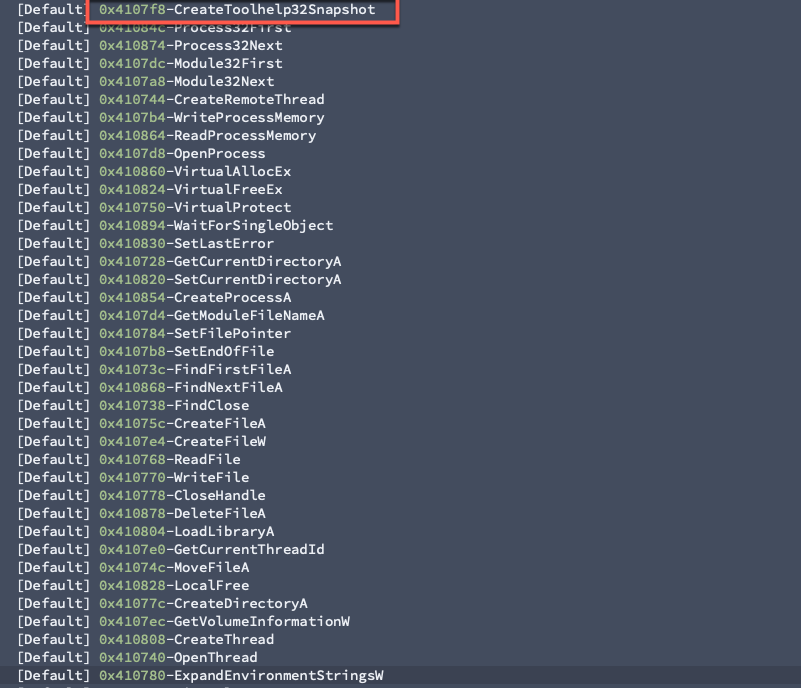  


All of the lookup tables for each dll import follow the same format. Qbot bot will eventually resolove the API names from the following DLLs:

* 0x410010->wininet.dll  
* 0x4100b8->wtsapi32.dll  
* 0x4100f4->netapi32.dll  
* 0x410580->user32.dll  
   

In [ ]:
from binaryninja import (binaryninja, BinaryReader, Symbol, SymbolType)

def decrypt_strings(offset):
    size = 0x373a  
    encrypted_strings_addr = 0x40b898
    decrypted = ""
    
    while offset < size: 
        key_addr = (offset & 0x3f)  + 0x410130
        br.seek(key_addr)
        key = br.read8()
        enc_byte = br.read(1, encrypted_strings_addr + offset)
        c = key ^ ord(enc_byte)
        if c == 0:
            break         
        
        decrypted += chr(c)
        offset += 1

    return decrypted

def rename_vars(addr, decrypted):
    # Rename symbol with resolved api name
    sym = Symbol(SymbolType.DataSymbol, addr, decrypted)
    
    # Gotta love that undo action
    bv.begin_undo_actions()
    bv.define_user_symbol(sym)
    
    print(f"{hex(addr)}-{decrypted}")
    
def calc_iat_size(ptr_addr):
    br.seek(ptr_addr)
    size = 0x0
    end_of_iat = 0x00000000
    current_val = br.read32()
    
    while current_val != end_of_iat:
        size += 0x4
        current_val = br.read32()
        
    return size
       
def resolve_api_names(ptrs):
    for ptr in ptrs:
        # read dll_name offset value (ptr + 8) and decrypt it
        dll_name_offset= br.read32(ptr + 8)
        dll_name = decrypt_strings(dll_name_offset)
        
        # rename ptr with name of dll to import
        rename_vars(ptr, dll_name)
        
        size = calc_iat_size(ptr)
        start_of_iat = ptr
        end_of_iat = ptr + size
        
        br.seek(start_of_iat)
        
        # The import table is <resolved_api_address>, <api_offset>, <dll_name_offset>
        while br.offset < end_of_iat:
            resolve_api_addr = br.read32()
            api_offset = br.read32()
        
            ret = br.offset # Reader to return to lookup table after decrypt
            
            api_name = decrypt_strings(api_offset)
            
            # skip the dll_name_offset since we already know it
            br.seek(ret + 4 )
            rename_vars(resolve_api_addr, api_name)
            
global br

br = BinaryReader(bv)

mw_decrypt_import_strings_addr = 0x40658b
mw_decrypt_strings_addr = 0x4064f7
mw_imports_resolve_addr = 0x4051e1

xrefs_40658b = bv.get_code_refs(mw_decrypt_import_strings_addr)
xrefs_4064f7 = bv.get_code_refs(mw_decrypt_strings_addr)
xrefs_4051e1 = bv.get_code_refs(mw_imports_resolve_addr) 

iat_ptrs = set() 

for refs in xrefs_4051e1:
    il = refs.function.get_llil_at(refs.address).mlil
    addr = il.params[0].value.value
    iat_ptrs.add(addr) 

resolve_api_names(iat_ptrs)

# Decrypt everything else
for xref in [xrefs_40658b, xrefs_4064f7]:
    for x in xref:
        il = x.function.get_llil_at(x.address).mlil
        try:
            offset = il.params[0].value.value
            
            if offset != 0:
                decrypted = decrypt_strings(offset)
                
                # Save decrypted string at xref addres as comment
                bv.begin_undo_actions()
                bv.set_comment_at(x.address, decrypted)

                print(f"{hex(x.address)}->{decrypted}")  
              
        except IndexError:
            continue

## Resource Extraction and Decryption  
Ref: https://github.com/jibsen/brieflz/blob/0ab07a51d838364064ff256b90b3cb7f48e5f15a/example/blzpack.c  

Since the above Qbot script has run we now have a nicely annotated database with the decrypted strings as comments and the correct data pointers are renamed with the resolved api names. This makes the rest of the analysis infinitely easier. Earlier in the Qbot lecture video we saw that the loader had several resources embedded and of note was a resource named `307` because of its rather large file size and the high entropy score.  

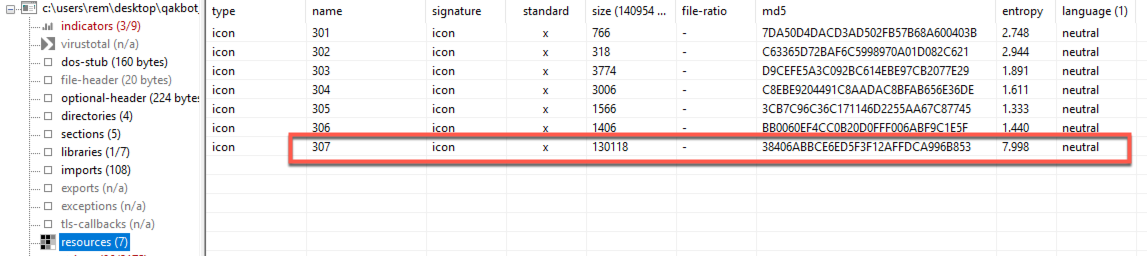  

The second clue is from the decoded strings. In the screenshot below we see a reference to the strings `307` at address `0x4012d3` and `308` at address `0x4016ea`.  

  

Both of those addresses are referenced in sub_40165f which i renamed to `mw_get_qbot_stage2_payload`. As you can see that Qbot expects to either have resources named either `307` or `308`.  





In [ ]:
from binaryninja import binaryninja
from binaryninja.debugger import debuggercontroller

# Connect to the remote debug server in the GUI before running this script
dbg = debuggercontroller.DebuggerController(bv)
dbg.executable_path = r'C:\Users\REM\Desktop\wqigacu.exe'
dbg.working_directory = r'C:\Users\REM\Desktop'

# Execute to main entry point 
dbg.launch()

dbg.execute_backend_command('bp kernelbase!VirtualProtect')

virtualprotect_hit = False

while dbg.breakpoints != None:
    dbg.go_and_wait()

    # Setup to start debugging just after unpacking
    if not virtualprotect_hit:
        virtualprotect_hit = True
        stack = dbg.get_reg_value("esp")
        ret = dbg.read_memory(stack, 0x4)
        ret_addr = int.from_bytes(bytes(ret), "little")
        dbg.add_breakpoint(ret_addr)

        stack = dbg.get_reg_value("esp") + 0x8 #2nd param to VirtualProtect
        size = dbg.read_memory(stack, 0x4)
        size_bytes = int.from_bytes(bytes(size), "little")
        
        # Execute until return then grab the unpacked payload
        dbg.go_and_wait()
        
    if dbg.ip == ret_addr:
        stack = dbg.get_reg_value("esp")
        payload_addr = dbg.read_memory(stack, 0x4) #Top of Stack
        payload_addr_bytes = int.from_bytes(bytes(payload_addr), "little")
        stage1_payload = dbg.read_memory(payload_addr_bytes, size_bytes)

        # Get the entry point of the newly unpacked sample 
        with binaryninja.load(stage1_payload, update_analysis=False) as bv2:
            ep = bv2.entry_point
            dbg.add_breakpoint(ep)
            
            # Cleanup old stuff
            dbg.delete_breakpoint(ret_addr)
            
            dbg.execute_backend_command('bc 1') # remove VirtualProtect bp
            bv.update_analysis()
            dbg.go_and_wait()

    # Stage 1 unpacked and at breakpoint at EP
    if dbg.ip == ep:
        print(f"[+] Searching for mw_get_qbot_stage2_payload address")
        #0040165f  55                 push    ebp {__saved_ebp}
        #00401660  8bec               mov     ebp, esp {__saved_ebp}
        #00401662  83ec18             sub     esp, 0x18
        #00401665  53                 push    ebx {__saved_ebx}  {0x0}
        #00401666  33db               xor     ebx, ebx
        #00401668  6a64               push    0x64 {__saved_esi}
        #0040166a  b8f4010000         mov     eax, 0x1f4
        #0040166f  b944114100         mov     ecx, data_411144
        #00401674  895de8             mov     dword [ebp-0x18 {var_1c}], ebx  {0x0}
        #00401677  895dfc             mov     dword [ebp-0x4 {var_8}], ebx  {0x0}
        #0040167a  895df0             mov     dword [ebp-0x10 {var_14}], ebx  {0x0}
        #0040167d  895df4             mov     dword [ebp-0xc {var_10}], ebx  {0x0}
        search = dbg.live_view.find_all_data(bv.start, bv.end, data=b"\x55\x8b\xec\x83\xec\x18\x53\x33\xdb\x6a\x64\xb8\xf4\x01\x00\x00\xb9",flags=FindFlag.FindCaseInsensitive)
        func_addr = search.results.get()
        print(f"[+] Found! mw_get_qbot_stage2_payload at:{hex(func_addr[0])}")

        dbg.add_breakpoint(func_addr[0])

        """Need to add anti-vm bypasses in order to continue debugging"""

        #dbg.go_and_wait() #<---I can't continue debugging because the view doesn't refresh
        break